# Preprocess artista

## Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

warnings.filterwarnings("ignore")

## Load the dataset

In [3]:
# Load the dataset.
dpi2_rep1 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/2DPI_1.h5ad"
)
dpi2_rep1.obsm["spatial"] = dpi2_rep1.obsm["spatial"] * np.array([-1, -1])
dpi2_rep1.X = dpi2_rep1.layers["counts"].copy()
print("loaded DPI2")

dpi5_rep1 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/5DPI_1.h5ad"
)
dpi5_rep1.obsm["spatial"] = dpi5_rep1.obsm["spatial"] * np.array([-1, -1])
dpi5_rep1.X = dpi5_rep1.layers["counts"].copy()
print("loaded DPI5")

dpi10_rep1 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/10DPI_1.h5ad"
)
dpi10_rep1.obsm["spatial"] = dpi10_rep1.obsm["spatial"] * np.array([-1, -1])
dpi10_rep1.X = dpi10_rep1.layers["counts"].copy()
dpi10_rep1 = dpi10_rep1[
    np.arange(dpi10_rep1.n_obs) != np.argmin(dpi10_rep1.obsm["spatial"][:, 0])
]
dpi10_rep1 = dpi10_rep1[
    np.arange(dpi10_rep1.n_obs) != np.argmin(dpi10_rep1.obsm["spatial"][:, 0])
]
dpi10_rep1 = dpi10_rep1[
    np.arange(dpi10_rep1.n_obs) != np.argmin(dpi10_rep1.obsm["spatial"][:, 0])
]
dpi10_rep1 = dpi10_rep1[
    np.arange(dpi10_rep1.n_obs) != np.argmin(dpi10_rep1.obsm["spatial"][:, 0])
]
print("loaded DPI10")

dpi15_rep4 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/15DPI_3.h5ad"
)
dpi15_rep4.obsm["spatial"] = dpi15_rep4.obsm["spatial"] * np.array([-1, -1])
dpi15_rep4 = dpi15_rep4[
    np.arange(dpi15_rep4.n_obs) != np.argmax(dpi15_rep4.obsm["spatial"][:, 1])
]
dpi15_rep4.X = dpi15_rep4.layers["counts"].copy()
print("loaded DPI15")

dpi20_rep2 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/20DPI_2.h5ad"
)
dpi20_rep2.obsm["spatial"] = dpi20_rep2.obsm["spatial"] * np.array([-1, -1])
dpi20_rep2.X = dpi20_rep2.layers["counts"].copy()
dpi20_rep2 = dpi20_rep2[
    np.arange(dpi20_rep2.n_obs) != np.argmin(dpi20_rep2.obsm["spatial"][:, 0])
]
dpi20_rep2 = dpi20_rep2[
    np.arange(dpi20_rep2.n_obs) != np.argmin(dpi20_rep2.obsm["spatial"][:, 0])
]
print("loaded DPI20")

dpi30 = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/30DPI.h5ad"
)
dpi30.obsm["spatial"] = dpi30.obsm["spatial"] * np.array([-1, -1])
dpi30.X = dpi30.layers["counts"].copy()
print("loaded DPI30")

adata = sc.concat((dpi2_rep1, dpi5_rep1, dpi10_rep1, dpi15_rep4, dpi20_rep2, dpi30))
adata.obs_names_make_unique()
del dpi2_rep1, dpi5_rep1, dpi10_rep1, dpi15_rep4, dpi20_rep2, dpi30

loaded DPI2
loaded DPI5
loaded DPI10
loaded DPI15
loaded DPI20
loaded DPI30


In [4]:
# Keep only injured half-hemisphere
adata = adata[adata.obs["inj_uninj"] == "inj"]
adata = adata[adata.obs["D_V"] == "D"]

In [5]:
adata

View of AnnData object with n_obs × n_vars = 14019 × 17176
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'Annotation'
    obsm: 'X_pca', 'X_spatial', 'spatial'
    layers: 'counts'

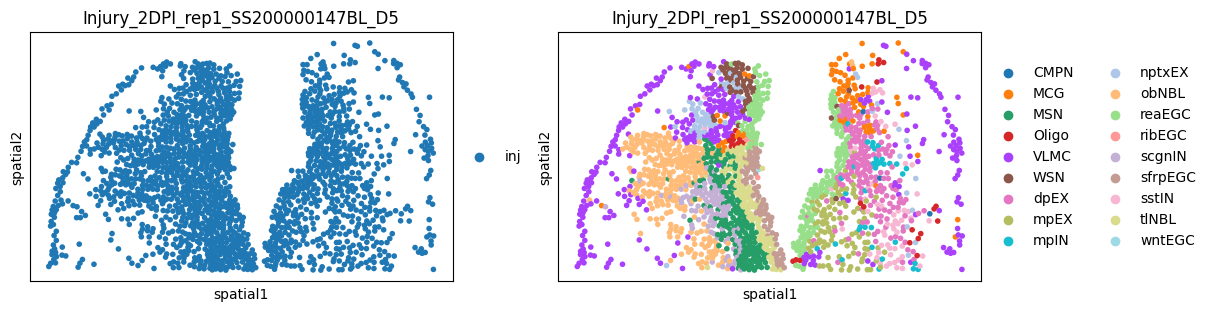

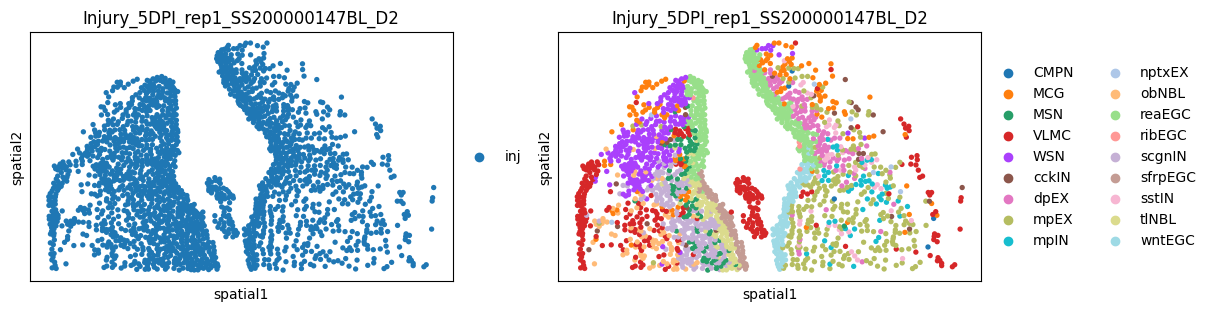

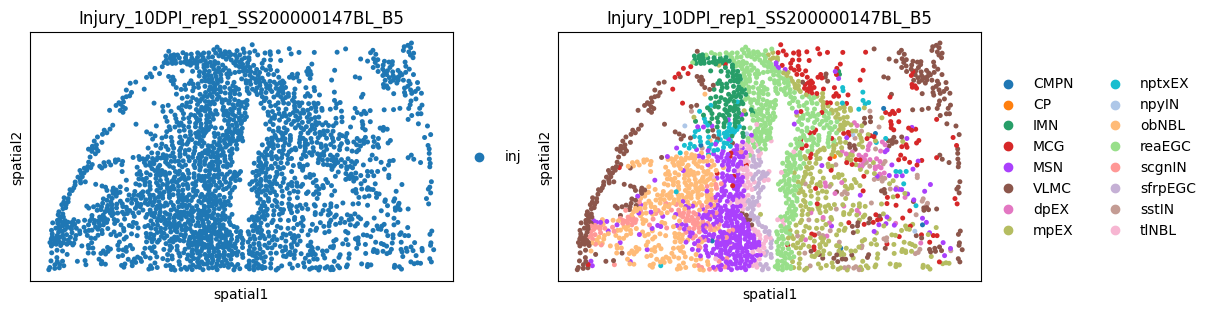

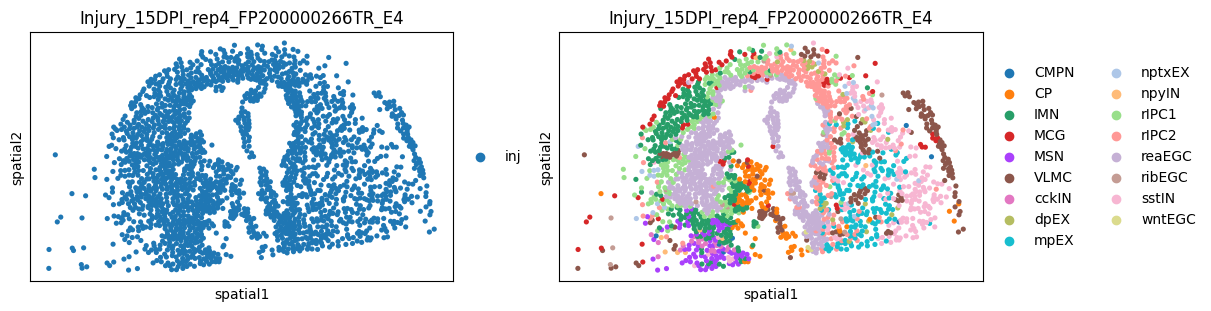

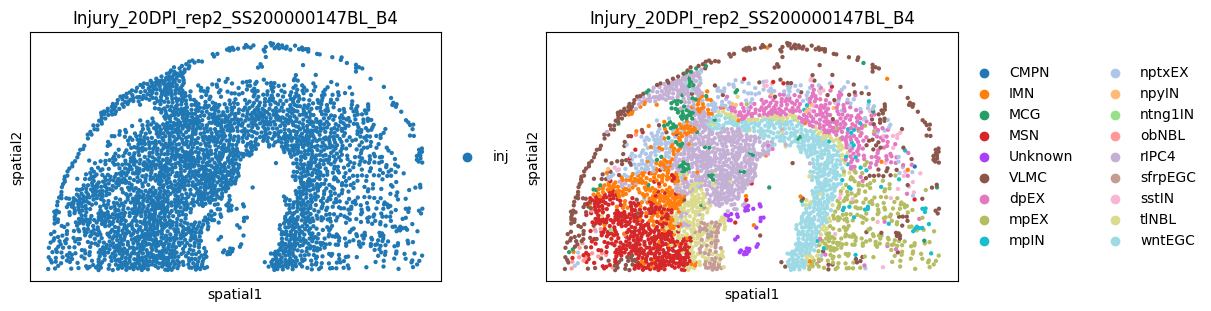

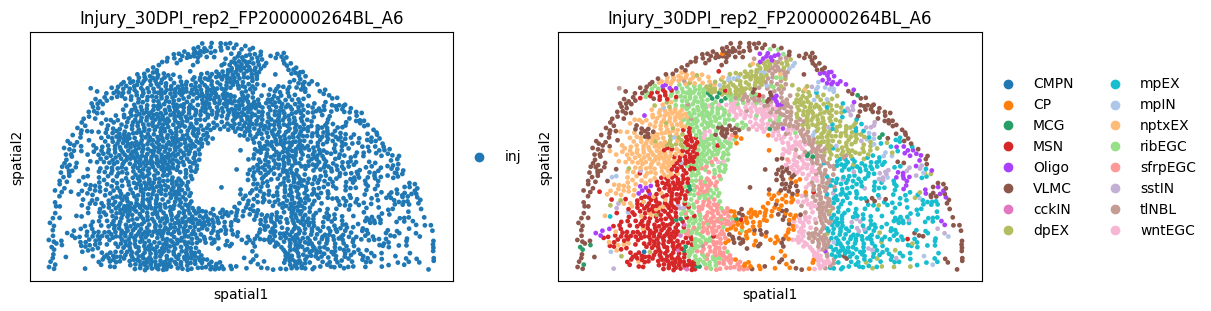

In [6]:
for b in adata.obs["Batch"].unique():
    idx = adata.obs["Batch"] == b
    fig, axes = plt.subplots(1, 2, figsize=(12, 3), constrained_layout=True)
    sc.pl.embedding(
        adata[idx], "spatial", color="inj_uninj", title=b, show=False, ax=axes[0]
    )
    sc.pl.embedding(
        adata[idx], "spatial", color="Annotation", title=b, show=False, ax=axes[1]
    )
    plt.show()

## Start preprocessing

In [7]:
adata.obs["Batch"].unique()

array(['Injury_2DPI_rep1_SS200000147BL_D5',
       'Injury_5DPI_rep1_SS200000147BL_D2',
       'Injury_10DPI_rep1_SS200000147BL_B5',
       'Injury_15DPI_rep4_FP200000266TR_E4',
       'Injury_20DPI_rep2_SS200000147BL_B4',
       'Injury_30DPI_rep2_FP200000264BL_A6'], dtype=object)

In [8]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [9]:
# Filter the counts.
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=adata.obs["n_genes_by_counts"].quantile(0.999))
sc.pp.filter_genes(adata, min_cells=3)
print("Filtered counts")

Filtered counts


## Proliferation and apoptosis

In [10]:
# from original publication
nsc = list(
    pd.read_csv(
        "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/nsc.txt",
        header=None,
    )[0]
)

In [11]:
# from https://github.com/theislab/moscot
human_apoptosis_genes = list(
    pd.read_csv(
        "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/apoptosis.txt",
        header=None,
    )[0]
)

In [12]:
idx = np.zeros_like(adata.var_names, dtype=bool)
for marker in human_apoptosis_genes:
    idx |= adata.var_names.str.contains(marker + " ")
axolotl_apoptosis_genes = list(adata.var_names[idx])
axolotl_apoptosis_genes

['ROCK1 | AMEX60DDU001007223',
 'PPP3R1 | AMEX60DDU001004500',
 'ATF3 | AMEX60DDU001003554',
 'TXNIP | AMEX60DDU001010091',
 'UPF2 | AMEX60DDU001009520',
 'UPF2 | AMEX60DDU001009513',
 'CD44 | AMEX60DDU001040132',
 'NDUFAF2 | AMEX60DDU001012395',
 'EGR3 | AMEX60DDU001006943',
 'LMF2 | AMEX60DD007932',
 'AVPR1A | AMEX60DD007737',
 'DCN | AMEX60DD007589',
 'ABCD2 | AMEX60DD007499',
 'TIMP3 | AMEX60DD007066',
 'CDKN1B | AMEX60DD006813',
 'PAK1 | AMEX60DD049715',
 'SLC35F2 | AMEX60DD049432',
 'DNAJC3 | AMEX60DD048619',
 'SATB1 | AMEX60DD022782',
 'SYF2 | AMEX60DD022454',
 'CTNNB1 | AMEX60DD022018',
 'PRAF2 | AMEX60DD021058',
 'TIMP1 | AMEX60DD020992',
 'CREBBP | AMEX60DD020289',
 'EAPP | AMEX60DD012213',
 'DNAAF2 | AMEX60DD011728',
 'BMF | AMEX60DD011543',
 'PFAS | AMEX60DD028069',
 'FAF2 | AMEX60DD027809',
 'SULF2 | AMEX60DD027586',
 'MLF2 | AMEX60DD026837',
 'CASP2 | AMEX60DD026314',
 'GADD45A | AMEX60DD019310',
 'MTF2 | AMEX60DD019154',
 'TGFBR3 | AMEX60DD019130',
 'BCL10 | AMEX60DD0190

In [13]:
idx = np.zeros_like(adata.var_names, dtype=bool)
for marker in nsc:
    idx |= adata.var_names.str.contains(marker)
nsc = list(adata.var_names[idx])
nsc

['TNFRSF19 | AMEX60DDU001006420',
 'RRM1[hs] | AMEX60DD049907',
 'VIM | AMEX60DD022108',
 'NES | AMEX60DD016851',
 'SOX2 | AMEX60DD001640',
 'LOC108799893[nr]|JUN[hs] | AMEX60DD043789',
 'SLC1A3 | AMEX60DD041912',
 'ID4 | AMEX60DD038483',
 'EFNB1 | AMEX60DD036933',
 'CCND1 | AMEX60DD005040',
 'SFRP1 | AMEX60DD002950',
 'CDH2 | AMEX60DD039579',
 'SLIT2 | AMEX60DD045792',
 'PDGFRA | AMEX60DD045542',
 'CCNA2 | AMEX60DD044899',
 'ABCG2 | AMEX60DD044011',
 'SOX9 | AMEX60DD031236',
 'KRT18 | AMEX60DD029807',
 'GFAP | AMEX60DD009861',
 'FABP7[nr] | AMEX60DD034100',
 'RRM2[hs] | AMEX60DD033253',
 'RGR | AMEX60DD052006',
 'LOC108783990[nr]|HES5[hs] | AMEX60DD051580',
 'TNC | AMEX60DD050822',
 'FZD5 | AMEX60DD055073']

In [14]:
sc.tl.score_genes(adata, axolotl_apoptosis_genes, score_name="apoptosis")

In [15]:
sc.tl.score_genes(adata, nsc, score_name="nsc")

In [16]:
def _logistic(x, L: float, k: float, center: float = 0):
    return L / (1 + np.exp(-k * (x - center)))


def _gen_logistic(p, sup: float, inf: float, center: float, width: float):
    return inf + _logistic(p, L=sup - inf, k=4.0 / width, center=center)


def beta(p, beta_max=1.7, beta_min=0.3, beta_center=0.25, beta_width=0.5):
    return _gen_logistic(p, beta_max, beta_min, beta_center, beta_width)


def delta(a, delta_max=1.7, delta_min=0.3, delta_center=0.1, delta_width=0.2):
    return _gen_logistic(a, delta_max, delta_min, delta_center, delta_width)


birth = beta(adata.obs["nsc"].values.astype(float))
death = delta(adata.obs["apoptosis"].values.astype(float))
adata.obs["growth"] = np.exp(birth - death)

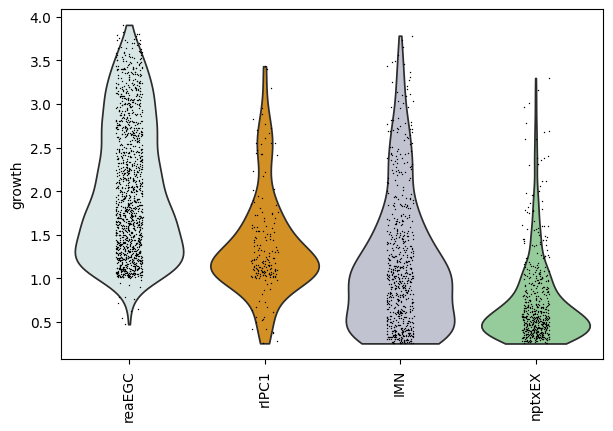

In [17]:
ax = sc.pl.violin(
    adata,
    "growth",
    "Annotation",
    show=False,
    rotation=90,
    order=["reaEGC", "rIPC1", "IMN", "nptxEX"],
)

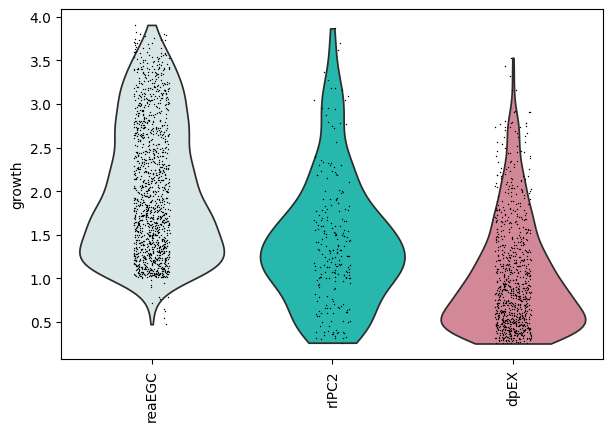

In [18]:
ax = sc.pl.violin(
    adata,
    "growth",
    "Annotation",
    show=False,
    rotation=90,
    order=["reaEGC", "rIPC2", "dpEX"],
)

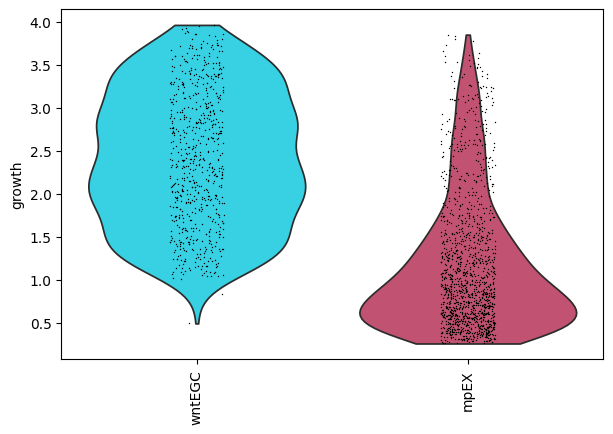

In [19]:
ax = sc.pl.violin(
    adata, "growth", "Annotation", show=False, rotation=90, order=["wntEGC", "mpEX"]
)

## Preprocess data

In [20]:
# Compute Pearson Residuals.
sc.experimental.pp.highly_variable_genes(
    adata,
    n_top_genes=10_000,
    batch_key="Batch",
    subset=True,
    chunksize=500,
)
sc.experimental.pp.normalize_pearson_residuals(adata)
print("Computed Pearson Residuals")

Computed Pearson Residuals


In [21]:
# Apply PCA.
sc.tl.pca(adata)
print("Computed PCA")

Computed PCA


In [22]:
adata.obs["time"] = (
    adata.obs["Batch"].str.split("_").str[1].str.replace("DPI", "").astype(float)
)

In [23]:
# Subset to the cell types of interest
idx = adata.obs["Annotation"].isin(
    [
        "nptxEX",
        "reaEGC",
        "wntEGC",
        "dpEX",
        "mpEX",
        "IMN",
        "rIPC1",
        "rIPC2",
    ]
)
adata = adata[idx]

In [24]:
# Integrate the batches.
sc.external.pp.harmony_integrate(adata, key="Batch", max_iter_harmony=20)
print("Integrated batches")

2024-04-04 10:27:57,682 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-04 10:27:59,236 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-04 10:27:59,267 - harmonypy - INFO - Iteration 1 of 20
2024-04-04 10:28:00,279 - harmonypy - INFO - Iteration 2 of 20
2024-04-04 10:28:01,296 - harmonypy - INFO - Iteration 3 of 20
2024-04-04 10:28:02,309 - harmonypy - INFO - Iteration 4 of 20
2024-04-04 10:28:03,337 - harmonypy - INFO - Iteration 5 of 20
2024-04-04 10:28:04,353 - harmonypy - INFO - Iteration 6 of 20
2024-04-04 10:28:05,111 - harmonypy - INFO - Iteration 7 of 20
2024-04-04 10:28:05,774 - harmonypy - INFO - Converged after 7 iterations


Integrated batches


In [25]:
# Compute the UMAP.
sc.pp.neighbors(adata, use_rep="X_pca_harmony", n_neighbors=200)
print("Computed neighbors")
sc.tl.umap(adata)
print("Computed UMAP")

Computed neighbors
Computed UMAP


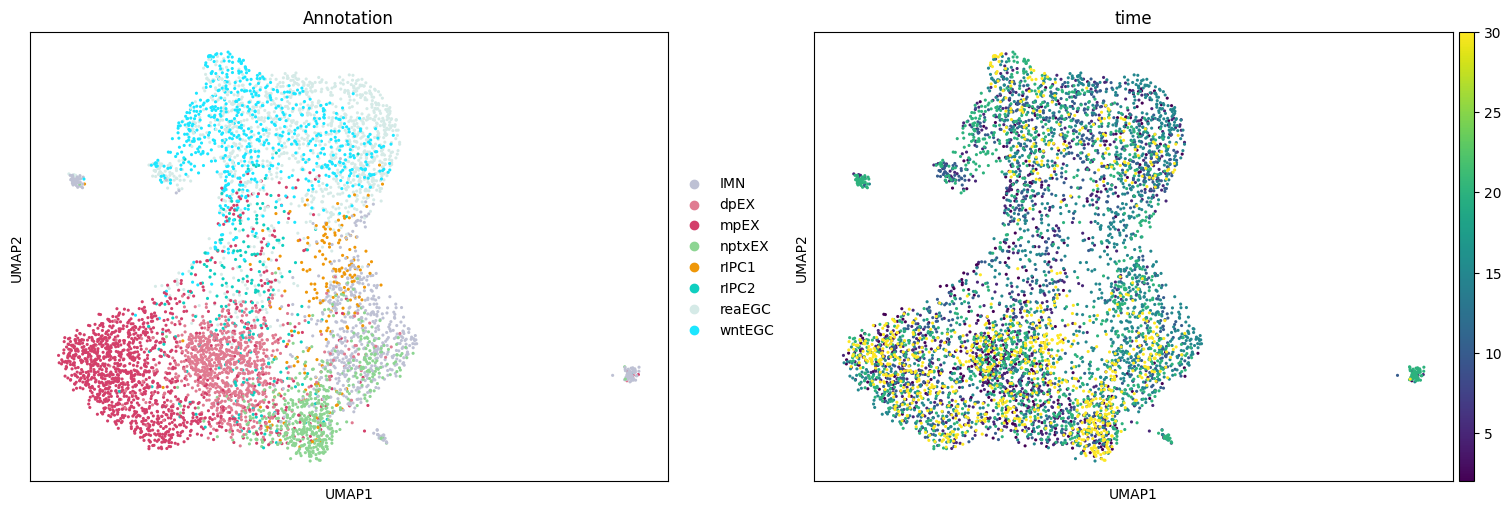

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
sc.pl.umap(adata, color="Annotation", show=False, ax=axes[0])
sc.pl.umap(adata, color="time", show=False, ax=axes[1], sort_order=False)
plt.savefig(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/artista_traj_processed.png"
)
plt.show()

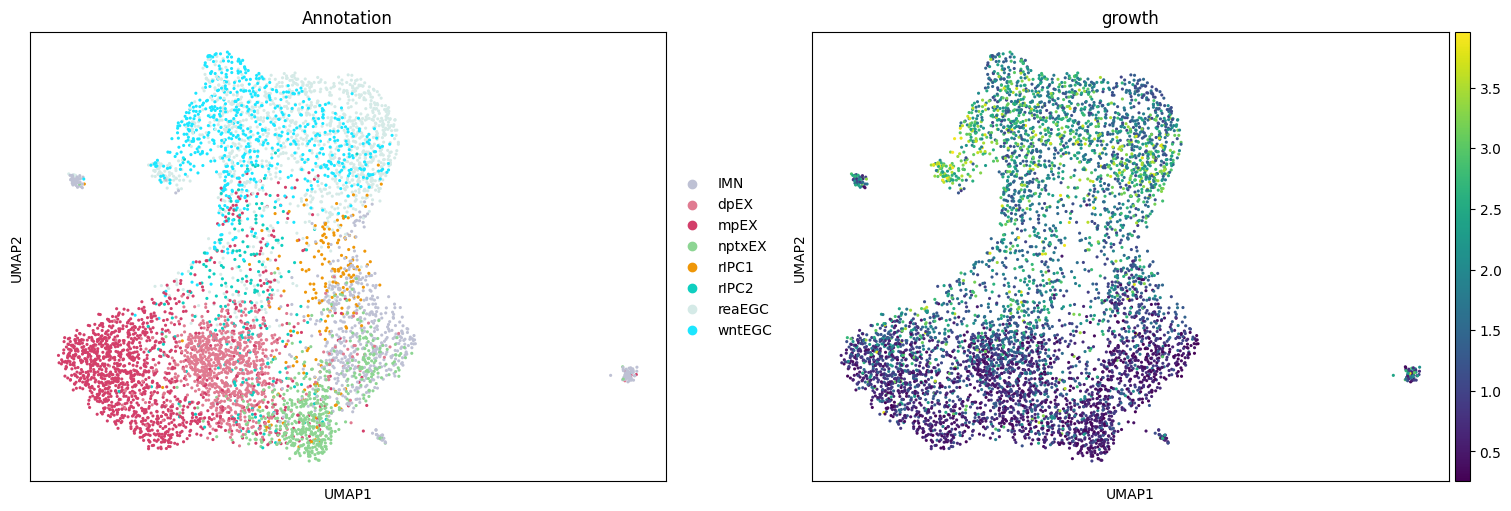

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
sc.pl.umap(adata, color="Annotation", show=False, ax=axes[0])
sc.pl.umap(adata, color="growth", show=False, ax=axes[1], sort_order=False)
plt.show()

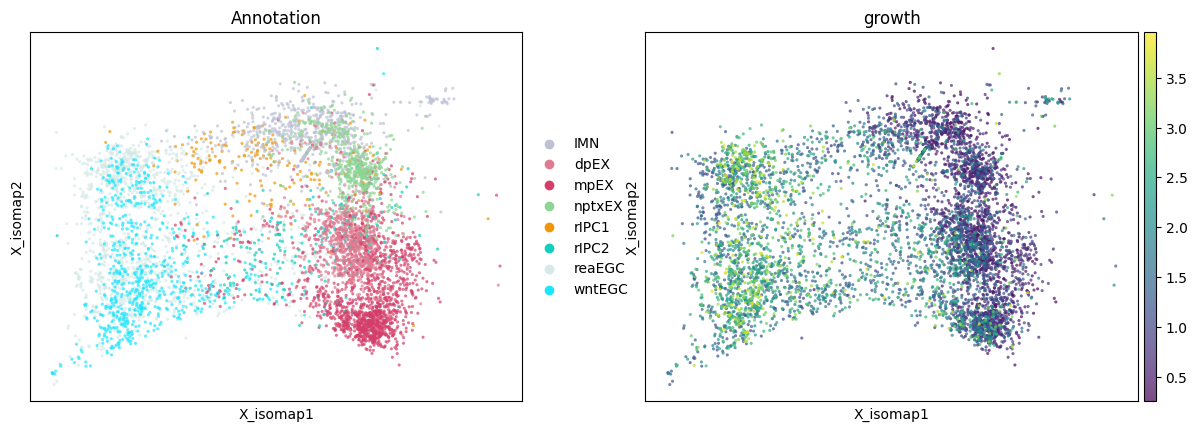

In [28]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=2)
adata.obsm["X_isomap"] = embedding.fit_transform(adata.obsm["X_pca_harmony"])
sc.pl.embedding(adata, basis="X_isomap", color=["Annotation", "growth"], alpha=0.7)

In [29]:
del adata.uns["pearson_residuals_normalization"]

In [30]:
# Save the data.
adata.write_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/artista/artista_traj_processed.h5ad"
)
print("Saved data")

Saved data


In [31]:
adata

AnnData object with n_obs × n_vars = 5904 × 10000
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'Annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'apoptosis', 'nsc', 'growth', 'time'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'Annotation_colors', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'spatial', 'X_pca_harmony', 'X_umap', 'X_isomap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'